In [1]:
# %pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --user

In [2]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib
from sklearn.preprocessing import MinMaxScaler

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [4]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers=ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [5]:
def ssl_indicator(df):
    sma_high = talib.SMA(df['high'], 10)
    sma_low = talib.SMA(df['low'], 10)
    hlv = [np.nan]
    for i in range(0, len(df['close'])):
        if df['close'][i] > sma_high[i]:
            hlv.append(1)
        elif df['close'][i] < sma_low[i]:
            hlv.append(-1)
        else:
            hlv.append(hlv[i-1])

    ssl_down = [sma_high[i] if hlv[i] < 0 else sma_low[i] for i in range(len(df.close))]
    ssl_up = [sma_low[i] if hlv[i] < 0 else sma_high[i] for i in range(len(df.close))]

    signals = []
    for i in range(0, len(df.close)):
        if ssl_up[i-1] < ssl_down[i-1] and ssl_up[i] > ssl_down[i]:
            signals.append(1)
        elif ssl_up[i-1] > ssl_down[i-1] and ssl_up[i] < ssl_down[i]:
            signals.append(-1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [6]:
def bbands_indicator(df):
    upper_bband_indicator, _, lower_bband_indicator = talib.BBANDS(df["close"], timeperiod=20)

    signals = []
    for i in range(0, len(df.close)):
        if upper_bband_indicator[i] < df['close'][i]:
            signals.append(-1)
        elif lower_bband_indicator[i] > df['close'][i]:
            signals.append(1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [7]:
def wavetrend_indicator(df):
    ap = (df['high'] + df['low'] + df['close']) / 3
    esa = talib.EMA(ap, 10)
    d = talib.EMA(np.abs(ap - esa), 10)
    ci = (ap - esa) / (0.015 * d)
    tci = talib.EMA(ci, 21)

    signals = []
    for i in range(0, len(tci)):
        if tci[i] > 60:
            signals.append(-1)
        elif tci[i] < -60:
            signals.append(1)
        else:
            signals.append(0)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [8]:
def produce_prediction(df, window):  
    prediction = (df.shift(window)['close'] <= df['close'])
    
    return prediction.astype(int)

In [97]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['high']
    low = df['low']
    close = df['close']
    
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    hl2 = (high + low) / 2
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        else:
            supertrend[curr] = supertrend[prev]

            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return final_lowerband, final_upperband

In [122]:
df = getTickerData('btc-usd', 'max', '1d')
df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
#df['date'] = pd.to_datetime(df['date']) 

[*********************100%***********************]  1 of 1 completed


In [141]:
mfi_indicator = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
all_ssl_signals, _, _ = ssl_indicator(df=df)
all_bbands_signals, _, _ = bbands_indicator(df=df)
close_b = produce_prediction(df, 1)
wavetrend_signals, _, _ = wavetrend_indicator(df)
final_lowerband, final_upperband = Supertrend(df, 10, 3)
fu_modified = [1 if not np.isnan(lowerband) else 0 for lowerband in final_lowerband]
fl_modified = [-1 if not np.isnan(upperband) else 0 for upperband in final_upperband]
final_supertrend_indicator = np.sum([fu_modified, fl_modified], axis=0)

df['close_binary'] = close_b
df['mfi'] = mfi_indicator
df['ssl_markover'] = all_ssl_signals
df['bbands'] = all_bbands_signals
df['wavetrend_signals'] = wavetrend_signals
df['supertrend'] = final_supertrend_indicator

In [115]:
df = df.drop(columns={"volume", "Adj Close", "open", "high", "low", "date"})
df = df.dropna()
df.tail(30)

,date,open,high,low,close,Adj Close,volume,close_binary,mfi,ssl_markover,bbands,wavetrend_signals,final_lowerband,final_upperband
3137,2023-04-20,28823.683594,29076.400391,28037.257812,28245.988281,28245.988281,21340360360,0,50.744072,-1,0,0,1,-1
3138,2023-04-21,28249.230469,28349.968750,27177.365234,27276.910156,27276.910156,20759504330,0,48.877478,0,0,0,1,-1
3139,2023-04-22,27265.894531,27872.142578,27169.570312,27817.500000,27817.500000,13125734602,1,49.566647,0,0,0,1,-1
3140,2023-04-23,27816.144531,27820.244141,27400.314453,27591.384766,27591.384766,12785446832,0,44.882256,0,0,0,1,-1
3141,2023-04-24,27591.730469,27979.982422,27070.849609,27525.339844,27525.339844,17703288330,0,37.692741,0,0,0,1,-1
3142,2023-04-25,27514.873047,28371.078125,27207.931641,28307.597656,28307.597656,17733373139,1,36.746031,0,0,0,1,-1
3143,2023-04-26,28300.058594,29995.837891,27324.548828,28422.701172,28422.701172,31854242019,1,47.041519,0,0,0,1,-1
3144,2023-04-27,28428.464844,29871.546875,28402.886719,29473.787109,29473.787109,27153445027,1,48.825210,0,0,0,1,-1
3145,2023-04-28,29481.013672,29572.791016,28929.609375,29340.261719,29340.261719,17544464887,0,47.642023,1,0,0,1,-1
3146,2023-04-29,29336.566406,29452.455078,29088.042969,29248.488281,29248.488281,10662634333,0,47.959302,0,0,0,1,-1


In [101]:
scaler = MinMaxScaler()
t_df = scaler.fit_transform(df)
t_df = pd.DataFrame(t_df, columns=df.columns)
t_df

,close,close_binary,mfi,ssl_markover,bbands,wavetrend_signals,final_lowerband,final_upperband
0,0.003050,0.0,0.445233,0.5,0.5,0.5,0.0,0.0
1,0.002923,0.0,0.466056,0.5,0.5,0.5,0.0,0.0
2,0.002692,0.0,0.479354,0.5,0.5,0.5,0.0,0.0
3,0.002237,0.0,0.375484,0.5,0.5,0.5,0.0,0.0
4,0.002113,0.0,0.336069,0.5,0.5,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...
3148,0.400877,1.0,0.441753,0.5,0.5,0.5,0.0,0.0
3149,0.398561,0.0,0.369893,0.5,0.5,0.5,0.0,0.0
3150,0.403936,1.0,0.354978,0.5,0.5,0.5,0.0,0.0
3151,0.395528,0.0,0.276445,0.5,0.5,0.5,0.0,0.0


In [53]:
def calculate_percentage_increase(final_value, starting_value):
    return 100 * ((final_value - starting_value) / starting_value)

In [54]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2

In [55]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()        
        self.df = df
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(len(Positions))
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        self.positions = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        
        self.trading_positions = 0
        self.profited_trading_positions = 0
        
        self.portfolio = 1
        
    def step(self, action):
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        reward, p, t = self.calculate_reward(action)
            
        if action != Positions.HOLD:
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
            
        self.positions.append(action)
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
            
        observation = self.get_observation()
        info = {'p': p, 't': t}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.positions.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        self.trading_positions = 0
        self.profited_trading_positions = 0
        self.portfolio = 1
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def final_render(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        
        winrate = round(self.profited_trading_positions / self.trading_positions, 5)
            
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        
        plt.figure(figsize=(20,7))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=6, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
        
        return winrate
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [56]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
        
    def calculate_reward(self, action):
        reward = 0
        percentage = 0.
        total_profit = 0
        amount_to_use = 0.05

        if self.in_a_pos and action != Positions.HOLD:
            percentage = calculate_percentage_increase(self.final_value, self.held_price)
            if self.current_pos == Positions.SHORT:
                percentage = -percentage
                
            total_profit += ((self.portfolio * amount_to_use) * percentage)
            portfolio_change = self.portfolio + ((self.portfolio * amount_to_use) * percentage)
            self.portfolio = portfolio_change
            
            self.trading_positions+=1
            if reward > 0:
                self.profited_trading_positions+=1
            
            reward = total_profit
            
            if reward < 0:
                reward *= 2
            
        return reward, percentage, total_profit

In [57]:
env = Trading(t_df, window_size=90, n_steps=100)
env = Monitor(env)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


REWARD 0
REWARD 0
REWARD 0.004988450828916961
REWARD -0.014089456562960671
REWARD 0.008969512610661161
REWARD 0
REWARD 0
REWARD 0
REWARD 0
REWARD -0.01989709033391683
REWARD -0.010244973625045447
REWARD -0.003427298734261454
REWARD 0
REWARD 0
REWARD 0.003238917007955219
REWARD 0.003181818673147416
REWARD 0.0055324382406286765
REWARD 0.0046047211100747705
REWARD -0.03214737078217129
REWARD -0.03096862994589448
REWARD 0
REWARD 0
REWARD -0.007421703411336827
REWARD 0
REWARD 0
REWARD -0.00922267647065963
REWARD 0.006924937799596686
REWARD -0.004504332445307686
REWARD 0
REWARD 0.009413346326528089
REWARD -0.0039775226539264154
REWARD 0.0044084690337590545
REWARD -0.005100182963301142
REWARD -0.006629554398109246
REWARD -0.00042648275922336034
REWARD 0.006275913977249122
REWARD 0.0012766697356485224
REWARD -0.0006827125240728676
REWARD 0
REWARD -0.005366992548834022
REWARD -0.001350492190384369
REWARD 0
REWARD 0
REWARD -0.007450933160657388
REWARD -0.0012835602340829596
REWARD 0
REWARD 0
REW

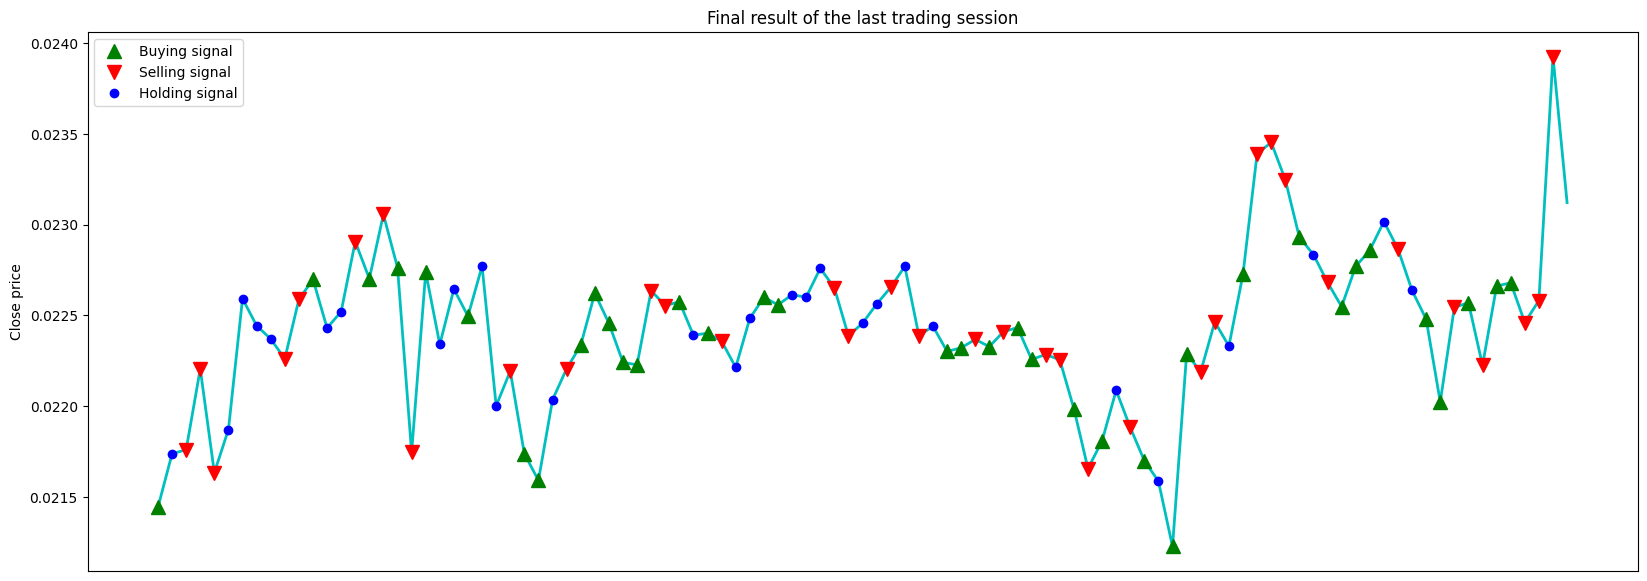

episode - 1 || score - -0.19235492384445158
0.0
-0.027127616368478748


In [58]:
episodes = 1
for n in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    ss = 0
    total_profit_ = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        print("REWARD", reward)
        # print('TOTAL_PROFIT', info['t'])
        total_profit_ += info["t"]
    winrate = env.final_render()
    print(f"episode - {n} || score - {score}")
    print(winrate)
    print(total_profit_)

In [15]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"
OPT_DIR = "./opt/"

In [16]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [223]:
def optimize_ppo(trial):
    return {
        "n_steps": trial.suggest_int("n_steps", 64, 8192),
        "gamma": trial.suggest_loguniform("gamma", 0.8, 0.9999),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
        "clip_range": trial.suggest_uniform("clip_range", 0.1, 0.4),
        "gae_lambda": trial.suggest_uniform("gae_lambda", 0.8, 0.99),
        "ent_coef": trial.suggest_uniform("ent_coef", 0.001, 0.01),
    }

In [224]:
def optimize_agent(trial):
    try:
        model_params=optimize_ppo(trial)
        env = Trading(df, window_size=90, n_steps=100)
        
        model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, **model_params)
        model.learn(100000)
        
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    except Exception as e:
        return -1000

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_agent, n_trials=35, n_jobs=1)

In [ ]:
study.best_params

{'n_steps': 7917,
 'gamma': 0.8148319613766952,
 'learning_rate': 1.1494222672968137e-05,
 'clip_range': 0.11454224768088915,
 'gae_lambda': 0.9747187305774679,
 'ent_coef': 0.007806731954039324}

In [18]:
model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=0,
    tensorboard_log=LOG_DIR,
    n_steps=7917,
    gamma=0.8148319613766952,
    learning_rate=1.1494222672968137e-05,
    clip_range=0.11454224768088915,
    gae_lambda=0.9747187305774679,
    ent_coef=0.007806731954039324,
)

In [59]:
loaded_model = RecurrentPPO.load("./saved_models/best_model_11200000_newr", env=env)

In [ ]:
opt_model = RecurrentPPO.load("./saved_models/opt_model_training_1", env=env)

In [18]:
loaded_model.learn(total_timesteps=3000000, callback=callback)

KeyboardInterrupt: 

In [21]:
evaluate_policy(model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(0.3768133655386919, 0.4695872432376318)

In [47]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

(4.0189118, 1.8294977040044516)

In [80]:
evaluate_policy(opt_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-0.006837816031838884, 0.07551070536538326)

In [60]:
def test_portfolio(model, starting_money, amount_to_use, total_episodes_to_run = 1):
    all_portfolio_accumulation_results = []
    all_final_portfolio_value = []
    all_score = []
    win = 0
    
    for episode in range(1, total_episodes_to_run+1):
        obs = env.reset()
        done = False
        score = 0
        portfolio = starting_money
        portfolio_accumulation_results = []
        percentage_increase = 0
        total_profit = 0
    
        while not done:
            action, lstm_cells = model.predict(obs)
            obs, reward, done, info = env.step(action)
            score += reward
            percentage_increase = info['p']
        
            total_profit += ((portfolio * amount_to_use) * percentage_increase)
            portfolio_change = portfolio + ((portfolio * amount_to_use) * percentage_increase)
            portfolio = portfolio_change
        
            portfolio_accumulation_results.append(portfolio_change)
        
        all_portfolio_accumulation_results.append(portfolio_accumulation_results)
        all_final_portfolio_value.append(portfolio)
        all_score.append(score)
        if total_profit > 0:
            win += 1
        
    fix, ax = plt.subplots()
    for i in range(0, len(all_portfolio_accumulation_results)):
        ax.plot(all_portfolio_accumulation_results[i])
    env.final_render()
    
    print(f'avg score - {np.average(all_score)}')
    print(f'avg final portfolio value - {np.average(all_final_portfolio_value)}')
    print(f'winrate - {win / total_episodes_to_run}')

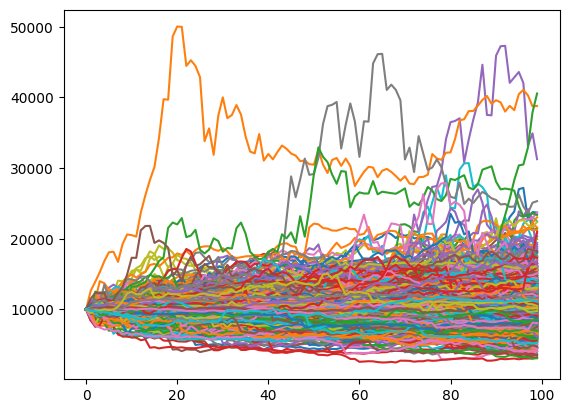

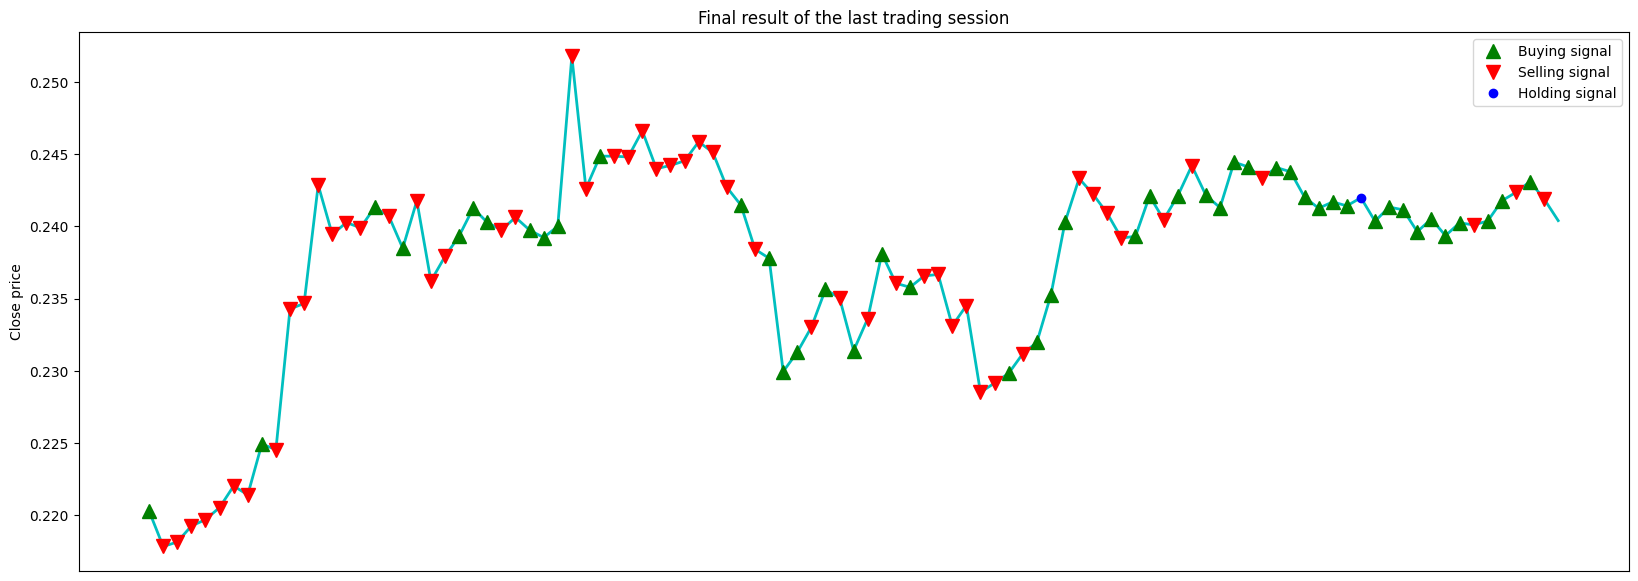

avg score - -0.9416680331484113
avg final portfolio value - 10619.44457306767
winrate - 0.52


In [61]:
test_portfolio(loaded_model, starting_money=10000, amount_to_use=0.05, total_episodes_to_run=1000)